# Regression Task

This notebook demonstrates a regression task using machine learning. This is a simple demonstration of regression neural network in PyTorch using a single hidden layer, one output layer and one hidden layer. The polynomials to be learnt are:

1) 2x^2 + 4x + 2
2) 4x^2 + 4x + 10 

raghudiddigi@gmail.com

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [95]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.hidden = nn.Linear(1, 64)  # One hidden layer with 10 neurons
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x


In [96]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):   
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [97]:
def custom_loss(model, criterion, outputs, y_data, old_params, param_importance, lambda_reg):
    normal_loss = criterion(outputs, y_data)
    reg_loss = 0.0
    for name, param in model.named_parameters():
        if param.requires_grad:
            reg_loss += torch.sum(param_importance[name] * (param - old_params[name]) ** 2)
    
    total_loss = normal_loss + lambda_reg * reg_loss
    return total_loss


In [98]:
np.random.seed(42)
x = np.random.uniform(-10, 10, 1000)
y = 2 * x**2 + 4 * x + 2
parameter_importance = {}
new_weights = {}
old_weights = {}

# Convert data to PyTorch tensors
x_train_1 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Shape: (5000, 1)
y_train_1 = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape: (500, 1)

dataset = CustomDataset(x_train_1, y_train_1)

dataloader_1 =DataLoader(dataset, batch_size=32, shuffle=True)  


In [99]:
def train_model(model,x_train,y_train,num_epochs,optimizer,device):
    losses = []
    global new_weights
    global old_weights
    old_weights = new_weights
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
    # Forward pass
        outputs = model(x_train.to(device))
        loss = criterion(outputs, y_train.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
            print()
    
    new_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


In [122]:
def train_model_with_custom_loss(model,x_train,y_train,num_epochs,optimizer,device):
    losses = []
    global new_weights
    global old_weights
    old_weights = new_weights
    for epoch in range(num_epochs):
    # Forward pass
        outputs = model(x_train.to(device))
        loss = custom_loss(model,nn.MSELoss(),outputs,y_train.to(device),old_weights,parameter_importance,100)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
            print()
    
    new_weights = {name: param.clone().detach() for name, param in model.named_parameters()}
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

cpu
Epoch [1000/20000], Loss: 466.6349

Epoch [2000/20000], Loss: 288.0119

Epoch [3000/20000], Loss: 145.8688

Epoch [4000/20000], Loss: 67.0783

Epoch [5000/20000], Loss: 32.0954

Epoch [6000/20000], Loss: 14.0096

Epoch [7000/20000], Loss: 5.2397

Epoch [8000/20000], Loss: 1.8828

Epoch [9000/20000], Loss: 0.6778

Epoch [10000/20000], Loss: 0.2472

Epoch [11000/20000], Loss: 0.0993

Epoch [12000/20000], Loss: 0.0426

Epoch [13000/20000], Loss: 0.0178

Epoch [14000/20000], Loss: 0.0077

Epoch [15000/20000], Loss: 0.0038

Epoch [16000/20000], Loss: 0.0020

Epoch [17000/20000], Loss: 0.0012

Epoch [18000/20000], Loss: 0.0008

Epoch [19000/20000], Loss: 0.0008

Epoch [20000/20000], Loss: 0.0007



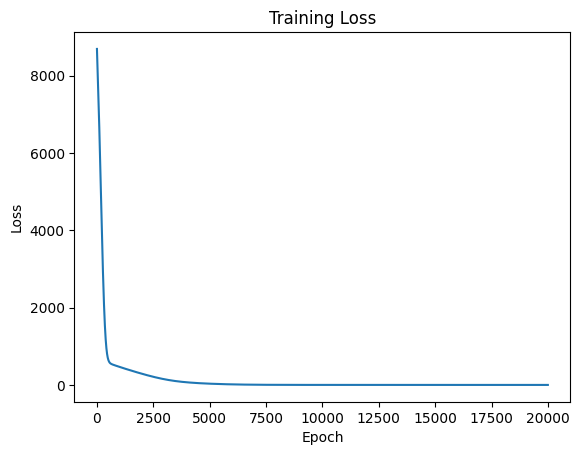

In [101]:
model_1 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

# Train the model_1
num_epochs = 20000
train_model(model_1,x_train_1,y_train_1,num_epochs,optimizer,device)

# Save the trained model
torch.save(model_1.state_dict(), "model_1.pth")

cpu
Epoch [1000/20000], Loss: 2126.8274

Epoch [2000/20000], Loss: 1579.7465

Epoch [3000/20000], Loss: 1115.2668

Epoch [4000/20000], Loss: 713.4037

Epoch [5000/20000], Loss: 423.8009

Epoch [6000/20000], Loss: 247.5757

Epoch [7000/20000], Loss: 131.5220

Epoch [8000/20000], Loss: 61.0108

Epoch [9000/20000], Loss: 25.8985

Epoch [10000/20000], Loss: 10.6501

Epoch [11000/20000], Loss: 3.4808

Epoch [12000/20000], Loss: 1.1682

Epoch [13000/20000], Loss: 0.4505

Epoch [14000/20000], Loss: 0.1937

Epoch [15000/20000], Loss: 0.0816

Epoch [16000/20000], Loss: 0.0346

Epoch [17000/20000], Loss: 0.0167

Epoch [18000/20000], Loss: 0.0083

Epoch [19000/20000], Loss: 0.0047

Epoch [20000/20000], Loss: 0.0036



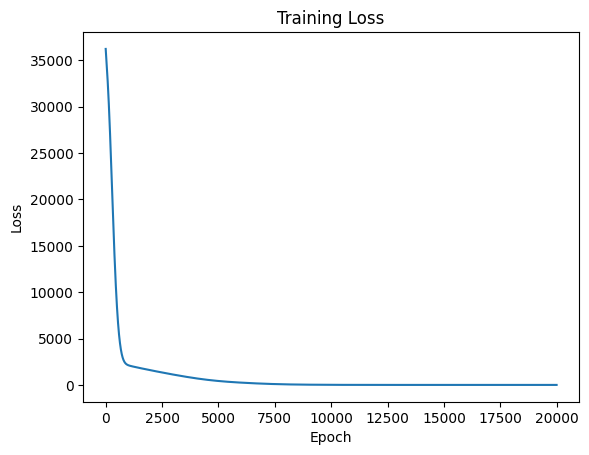

In [102]:
np.random.seed(42)
x = np.random.uniform(-10, 10, 1000)
y = 4 * x**2 + 4 * x + 10

# Convert data to PyTorch tensors
x_train_2 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Shape: (5000, 1)
y_train_2 = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape: (500, 1)

dataset = CustomDataset(x_train_2, y_train_2)

dataloader_2 =DataLoader(dataset, batch_size=32, shuffle=True)

model_2 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

# Train the model_2
num_epochs = 20000
train_model(model_2,x_train_2,y_train_2,num_epochs,optimizer,device)
torch.save(model_2.state_dict(), "model_2.pth")


cpu
Epoch [1000/20000], Loss: 5332.9458

Epoch [2000/20000], Loss: 4014.7620

Epoch [3000/20000], Loss: 2998.1135

Epoch [4000/20000], Loss: 2070.7747

Epoch [5000/20000], Loss: 1282.6932

Epoch [6000/20000], Loss: 738.0900

Epoch [7000/20000], Loss: 395.5648

Epoch [8000/20000], Loss: 185.8433

Epoch [9000/20000], Loss: 76.5124

Epoch [10000/20000], Loss: 31.6760

Epoch [11000/20000], Loss: 13.4017

Epoch [12000/20000], Loss: 5.4115

Epoch [13000/20000], Loss: 1.9654

Epoch [14000/20000], Loss: 0.7553

Epoch [15000/20000], Loss: 0.3116

Epoch [16000/20000], Loss: 0.1315

Epoch [17000/20000], Loss: 0.0578

Epoch [18000/20000], Loss: 0.0267

Epoch [19000/20000], Loss: 0.0132

Epoch [20000/20000], Loss: 0.0083



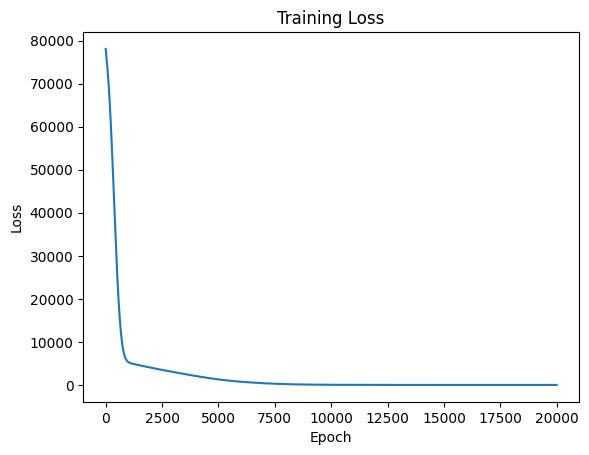

In [103]:
np.random.seed(42)
x = np.random.uniform(-10, 10, 1000)
y = 6 * x**2 + 7 * x + 9

# Convert data to PyTorch tensors
x_train_3 = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # Shape: (5000, 1)
y_train_3 = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape: (500, 1)

dataset = CustomDataset(x_train_3, y_train_3)
dataloader_3 =DataLoader(dataset, batch_size=32, shuffle=True)

model_3 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_3.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

# Train the model_3
num_epochs = 20000

train_model(model_3,x_train_3,y_train_3,num_epochs,optimizer,device)
torch.save(model_3.state_dict(), "model_3.pth")

cpu
Epoch [1000/20000], Loss: 485.1264

Epoch [2000/20000], Loss: 301.6613

Epoch [3000/20000], Loss: 153.5050

Epoch [4000/20000], Loss: 68.3575

Epoch [5000/20000], Loss: 30.4183

Epoch [6000/20000], Loss: 12.4203

Epoch [7000/20000], Loss: 4.8336

Epoch [8000/20000], Loss: 1.8608

Epoch [9000/20000], Loss: 0.6808

Epoch [10000/20000], Loss: 0.2485

Epoch [11000/20000], Loss: 0.0994

Epoch [12000/20000], Loss: 0.0430

Epoch [13000/20000], Loss: 0.0182

Epoch [14000/20000], Loss: 0.0078

Epoch [15000/20000], Loss: 0.0037

Epoch [16000/20000], Loss: 0.0020

Epoch [17000/20000], Loss: 0.0013

Epoch [18000/20000], Loss: 0.0010

Epoch [19000/20000], Loss: 0.0008

Epoch [20000/20000], Loss: 0.0010



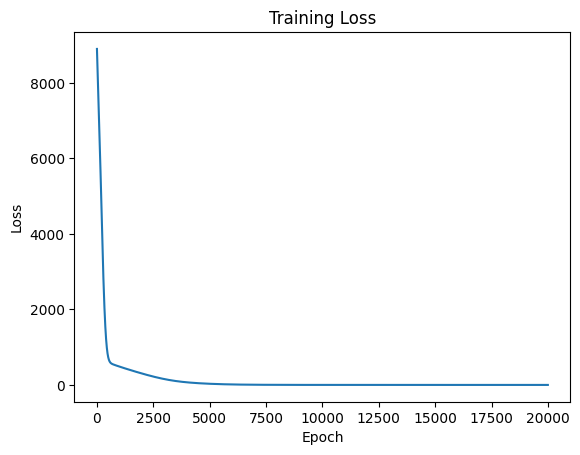

In [123]:
model_4 = RegressionModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model_4.to(device)
print(device)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.001)

# Train the model_2
num_epochs = 20000
train_model(model_4,x_train_1,y_train_1,num_epochs,optimizer,device)

In [125]:
def calculate_importance_weights(model, x_data, y_data, parameter_importance):
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    model.to(device)

    outputs = model(x_data)
    loss = criterion(outputs, y_data)

    optimizer.zero_grad()

    loss.backward()
    for name, param in model.named_parameters():
        if param.grad is not None:
            if name in parameter_importance:
                parameter_importance[name] += abs(param.grad.clone().detach())
            else:
                parameter_importance[name] = abs(param.grad.clone().detach())
    
    return parameter_importance


In [126]:
def update_param_importance(dataloader):
    for batch in dataloader:
        x_data, y_data = batch
        global parameter_importance
        parameter_importance = calculate_importance_weights(model_4, x_data, y_data, parameter_importance)

    for keys,values in parameter_importance.items():
        values = values/len(dataloader)

    print(parameter_importance)

In [127]:
update_param_importance(dataloader_1)

{'hidden.weight': tensor([[ 74.4121],
        [ 51.7184],
        [ 39.0573],
        [ 28.5259],
        [ 93.5608],
        [ 64.9614],
        [ 55.3992],
        [ 36.8705],
        [ 94.1771],
        [ 72.4014],
        [ 54.3024],
        [ 46.6631],
        [ 46.8320],
        [ 32.9306],
        [ 31.2910],
        [ 57.6064],
        [ 46.1811],
        [175.9187],
        [ 89.0062],
        [114.0873],
        [ 78.6135],
        [ 47.9667],
        [ 49.7790],
        [ 57.7156],
        [156.3429],
        [ 28.1195],
        [108.1105],
        [106.9276],
        [ 74.6418],
        [456.8176],
        [ 50.5247],
        [ 62.4271],
        [ 92.7344],
        [ 19.8325],
        [ 55.2331],
        [ 25.7567],
        [202.6735],
        [ 52.9861],
        [ 84.7285],
        [ 90.1868],
        [ 33.0731],
        [ 51.0116],
        [ 78.6520],
        [ 53.4178],
        [ 32.0218],
        [ 64.7776],
        [ 49.1392],
        [ 47.9334],
        [ 68.3825],
  

Epoch [1000/20000], Loss: 7376.5020

Epoch [2000/20000], Loss: 7376.5024

Epoch [3000/20000], Loss: 7376.5029

Epoch [4000/20000], Loss: 7376.5020

Epoch [5000/20000], Loss: 7376.5020

Epoch [6000/20000], Loss: 7376.5020

Epoch [7000/20000], Loss: 7376.5020

Epoch [8000/20000], Loss: 7376.5020

Epoch [9000/20000], Loss: 7376.5015

Epoch [10000/20000], Loss: 7376.5020

Epoch [11000/20000], Loss: 7376.5024

Epoch [12000/20000], Loss: 7376.5015

Epoch [13000/20000], Loss: 7376.5029

Epoch [14000/20000], Loss: 7376.5024

Epoch [15000/20000], Loss: 7376.5020

Epoch [16000/20000], Loss: 7376.5024

Epoch [17000/20000], Loss: 7376.5034

Epoch [18000/20000], Loss: 7376.5024

Epoch [19000/20000], Loss: 7376.5020

Epoch [20000/20000], Loss: 7376.5029



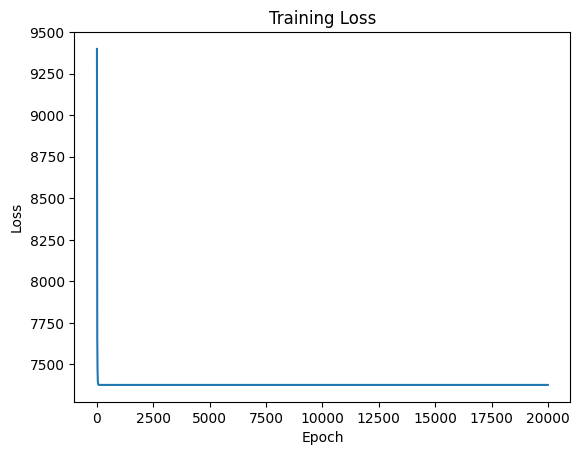

{'hidden.weight': tensor([[   74.4121],
        [25404.8672],
        [27112.0293],
        [20891.7617],
        [13035.4023],
        [15229.0869],
        [ 9322.6416],
        [21629.7207],
        [21359.4180],
        [ 9484.8643],
        [23986.6719],
        [19813.3711],
        [20427.1035],
        [25686.5469],
        [10347.0771],
        [13274.4863],
        [ 9001.8105],
        [26145.6523],
        [15283.4404],
        [19462.8281],
        [15307.6260],
        [ 7993.3047],
        [18040.7129],
        [ 9009.4375],
        [12590.4434],
        [25933.5801],
        [20723.0371],
        [23040.7266],
        [10238.3643],
        [15670.9678],
        [10449.1113],
        [ 8865.0771],
        [ 8529.3887],
        [29155.8477],
        [32117.6191],
        [10197.7529],
        [21636.5449],
        [22790.0293],
        [19968.3848],
        [ 9009.9111],
        [ 9111.8867],
        [18975.3301],
        [10983.6377],
        [ 6704.7490],
        [17554

In [128]:
train_model_with_custom_loss(model_4,x_train_2,y_train_2,num_epochs,optimizer,device)

update_param_importance(dataloader_2)

Epoch [1000/20000], Loss: 27079.6660

Epoch [2000/20000], Loss: 27079.6680

Epoch [3000/20000], Loss: 27079.6660

Epoch [4000/20000], Loss: 27079.6699

Epoch [5000/20000], Loss: 27079.7773

Epoch [6000/20000], Loss: 27079.7500

Epoch [7000/20000], Loss: 27079.7656

Epoch [8000/20000], Loss: 27079.7207

Epoch [9000/20000], Loss: 27079.7578

Epoch [10000/20000], Loss: 27079.7578

Epoch [11000/20000], Loss: 27079.7773

Epoch [12000/20000], Loss: 27079.7500

Epoch [13000/20000], Loss: 27079.7949

Epoch [14000/20000], Loss: 27079.7676

Epoch [15000/20000], Loss: 27079.8184

Epoch [16000/20000], Loss: 27079.8164

Epoch [17000/20000], Loss: 27079.7363

Epoch [18000/20000], Loss: 27079.8711

Epoch [19000/20000], Loss: 27079.7637

Epoch [20000/20000], Loss: 27079.8516



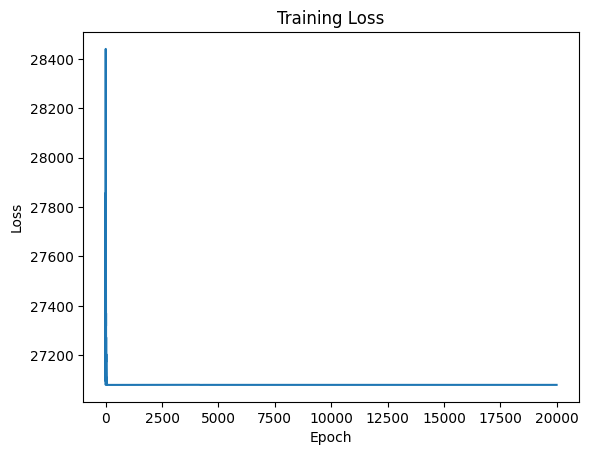

In [129]:
train_model_with_custom_loss(model_4,x_train_3,y_train_3,num_epochs,optimizer,device)

In [130]:
model_4.eval()

# Initialize x_test and y_test
x_test = torch.tensor([])
y_test = torch.tensor([])

# Randomly sample 200 samples
indices = torch.randperm(x_train_1.size(0))[:200]

x_sample = x_train_1[indices]
y_sample = y_train_1[indices]

# Append to x_test and y_test
x_test = torch.cat((x_test, x_sample))
y_test = torch.cat((y_test, y_sample))

indices = torch.randperm(x_train_2.size(0))[:200]

x_sample = x_train_2[indices]
y_sample = y_train_2[indices]  

x_test = torch.cat((x_test, x_sample))
y_test = torch.cat((y_test, y_sample))

indices = torch.randperm(x_train_3.size(0))[:200]

x_sample = x_train_3[indices]
y_sample = y_train_3[indices]  

x_test = torch.cat((x_test, x_sample))
y_test = torch.cat((y_test, y_sample))

x_test = x_test.to(device)
y_test = y_test.to(device)
model_4.to(device)

outputs = model_4(x_test)

y_pred = outputs.detach().numpy()

y_avg = 4 * x_test.numpy()**2 + 4 * x_test.numpy() + 7

outputs_1 = model_1(x_test)
outputs_2 = model_2(x_test)
outputs_3 = model_3(x_test)

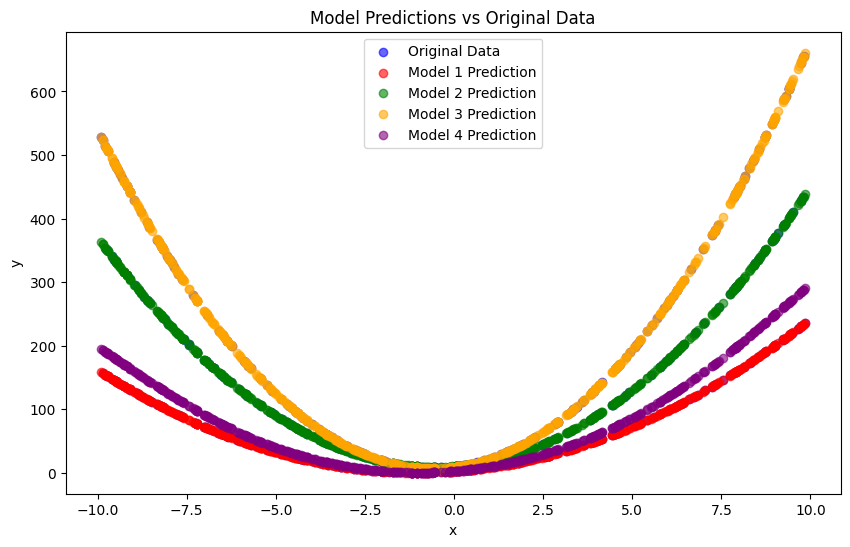

Model 1 MSE: 15016.5186
Model 2 MSE: 6131.9868
Model 3 MSE: 15542.6338
Model 4 MSE: 11223.4619


In [131]:
# plt.figure(figsize=(10, 6))
# plt.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), label="Original Data", color="blue", alpha=0.6)

# Model predictions
y_pred_1 = outputs_1.detach().cpu().numpy()
y_pred_2 = outputs_2.detach().cpu().numpy()
y_pred_3 = outputs_3.detach().cpu().numpy()
y_pred_4 = outputs.detach().cpu().numpy()

# import matplotlib.pyplot as plt
# import numpy as np

plt.figure(figsize=(10, 6))

# Scatter plot for original data
plt.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), label="Original Data", color="blue", alpha=0.6)

# Model predictions - Use scatter instead of plot
plt.scatter(x_test.cpu().numpy(), y_pred_1, label="Model 1 Prediction", color="red", alpha=0.6)
plt.scatter(x_test.cpu().numpy(), y_pred_2, label="Model 2 Prediction", color="green", alpha=0.6)
plt.scatter(x_test.cpu().numpy(), y_pred_3, label="Model 3 Prediction", color="orange", alpha=0.6)
plt.scatter(x_test.cpu().numpy(), y_pred_4, label="Model 4 Prediction", color="purple", alpha=0.6)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Model Predictions vs Original Data")
plt.show()


# Calculating Mean Squared Error for each model
mse_1 = np.mean((y_pred_1 - y_test.cpu().numpy())**2)
mse_2 = np.mean((y_pred_2 - y_test.cpu().numpy())**2)
mse_3 = np.mean((y_pred_3 - y_test.cpu().numpy())**2)
mse_4 = np.mean((y_pred_4 - y_test.cpu().numpy())**2)

print(f"Model 1 MSE: {mse_1:.4f}")
print(f"Model 2 MSE: {mse_2:.4f}")
print(f"Model 3 MSE: {mse_3:.4f}")
print(f"Model 4 MSE: {mse_4:.4f}")

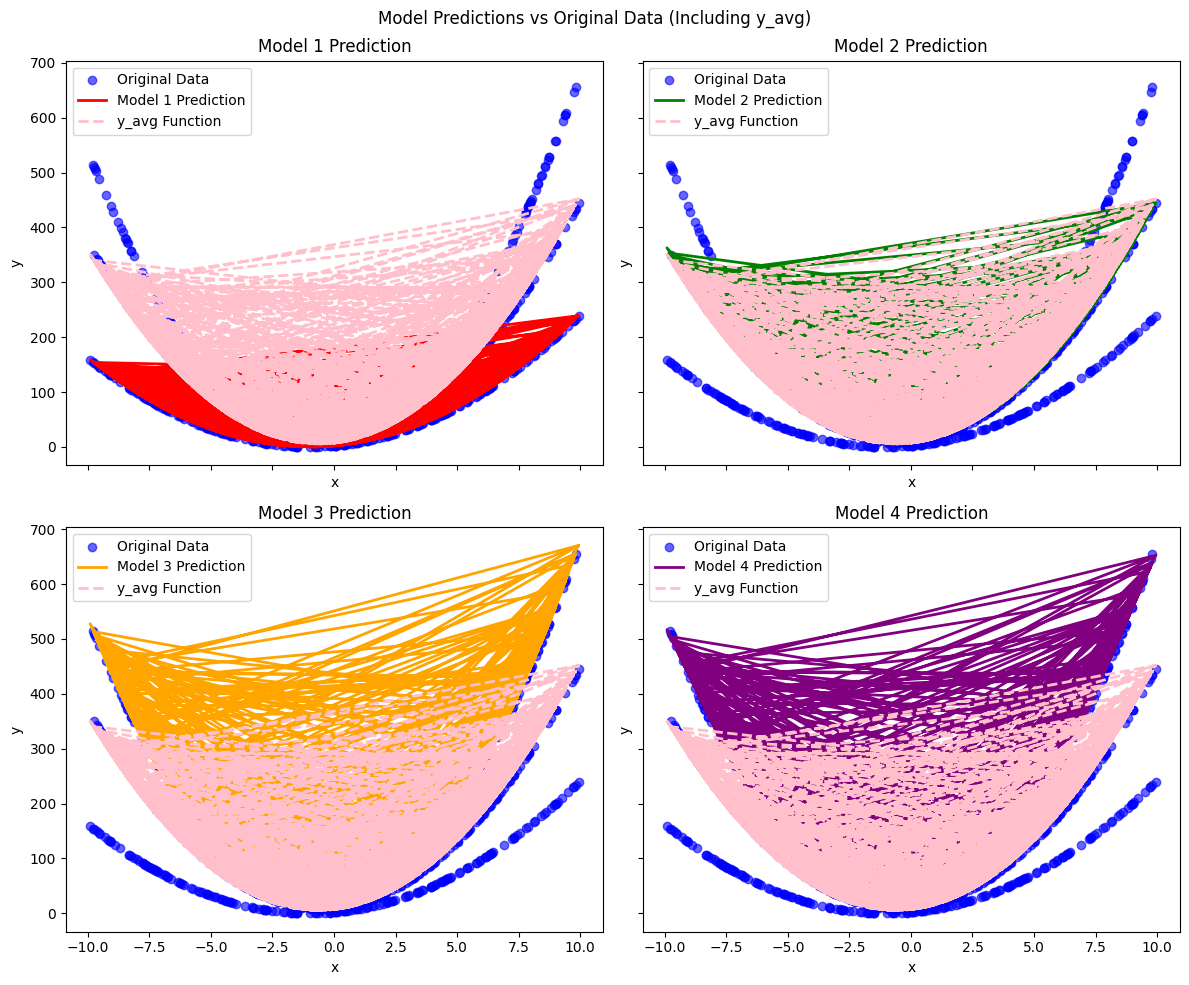

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

models = [
    (y_pred_1, "Model 1 Prediction", "red"),
    (y_pred_2, "Model 2 Prediction", "green"),
    (y_pred_3, "Model 3 Prediction", "orange"),
    (y_pred_4, "Model 4 Prediction", "purple"),
]

x_vals = x_test.cpu().numpy()
y_vals = y_test.cpu().numpy()
y_avg = 4 * x_vals**2 + 5 * x_vals + 7  # Defined function

for i, (y_pred, title, color) in enumerate(models):
    axes[i].scatter(x_vals, y_vals, label="Original Data", color="blue", alpha=0.6)
    axes[i].plot(x_vals, y_pred, label=title, color=color, linewidth=2)
    axes[i].plot(x_vals, y_avg, label="y_avg Function", color="pink", linestyle="dashed", linewidth=2)  # Added y_avg
    axes[i].set_title(title)
    axes[i].legend()
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")

plt.suptitle("Model Predictions vs Original Data (Including y_avg)")
plt.tight_layout()
plt.show()

In [113]:
# print(old_weights)
# print(new_weights)